In [22]:
import numpy as np
import pandas as pd 
from scipy import stats

import toolsIO as io 
from params import DECADES, COLORMAP

import matplotlib.pyplot as plt
from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, roc_auc_score, matthews_corrcoef, log_loss, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

# Loading DataFrame

In [23]:
repr_mode = 'sgns'
distance = 'cosine'
pos = 'N'

model_name = repr_mode + '_' + distance
word_list, word2ind = io.getTargets(pos,repr_mode)


In [68]:
synpairs_df = io.getSynpairsInfos(pos, model_name)
synpairs_df['absFEv_entry'] = synpairs_df.FEv_entry.abs()
synpairs_df['absFEv_syn'] = synpairs_df.FEv_syn.abs()
synpairs_df['normLev'] = synpairs_df.Lev /((synpairs_df.entry.str.len()+synpairs_df.syn.str.len())/2)
synpairs_df['FqDO'] = (synpairs_df.FGO_entry - synpairs_df.FGO_syn)
synpairs_df['FqDE'] = (synpairs_df.FGE_entry - synpairs_df.FGE_syn)
synpairs_df['DDGpair_atleast1'] = synpairs_df['DiachrDG_pair_avgstd'].astype(bool)
synpairs_df['DDGpair_both'] = (synpairs_df['DiachrDG_pair_avgstd'] == 'both')
synpairs_df['DeltaDD'] = (synpairs_df.DiachrD_entry - synpairs_df.DiachrD_syn).abs()
synpairs_df

,entry,syn,pressure_entry,syns_WordNet,WNpressure_entry,WNsenses_entry,WNsenses_syn,syns_WNExt,WNExt_word,DiachrD_entry,...,Dec_avg,Dec_avgstd,absFEv_entry,absFEv_syn,normLev,FqDO,FqDE,DDGpair_atleast1,DDGpair_both,DeltaDD
pairIdx,,,,,,,,,,,,,,,,,,,,,
0,abbreviation,abridgment,2,False,0,2,1,False,,0.857143,...,LD,LPC,0,0,0.727273,0,0,True,False,0.127629
1,abbreviation,contraction,2,False,0,2,4,False,,0.857143,...,LD,LD,0,1,0.695652,-1,0,False,False,0.208494
2,abomination,abhorrence,16,True,5,3,1,True,,0.918919,...,LD,LD,0,0,0.857143,0,0,False,False,0.036237
3,abomination,curse,16,False,5,3,5,False,,0.918919,...,LPC,LPC,0,1,1.375000,-2,-1,False,False,0.161155
4,abomination,hatred,16,False,5,3,1,False,,0.918919,...,LD,LPC,0,0,1.058824,-2,-2,False,False,0.337359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2313,work,business,12,False,6,7,9,False,,0.837209,...,LD,LPC,0,0,1.333333,0,0,False,False,0.056721
2314,work,employment,12,True,6,7,4,True,,0.837209,...,LPC,LPC,0,0,1.285714,1,1,False,False,0.019934
2315,work,performance,12,False,6,7,5,False,,0.837209,...,LD,LD,0,1,1.200000,1,0,False,False,0.039195


In [25]:
synpairs_df.syns_WordNet.value_counts()

False    2004
True      314
Name: syns_WordNet, dtype: int64

In [26]:
synpairs_df.syns_WNExt.value_counts()

False    1829
True      489
Name: syns_WNExt, dtype: int64

In [27]:
synpairs_df.columns

Index(['entry', 'syn', 'pressure_entry', 'syns_WordNet', 'WNpressure_entry',
       'WNsenses_entry', 'WNsenses_syn', 'syns_WNExt', 'WNExt_word',
       'DiachrD_entry', 'DiachrD_syn', 'DiachrDG_entry', 'DiachrDG_syn',
       'DiachrDG_pair_avg', 'DiachrDG_pair_avgstd', 'FO_entry', 'FO_syn',
       'FE_entry', 'FE_syn', 'EnoughFreq', 'FGO_entry', 'FGO_syn', 'FGE_entry',
       'FGE_syn', 'FEv_entry', 'FEv_syn', 'Lev', 'SDO', 'SDE', 'Div', 'SDGO',
       'SDGE', 'Dec_avg', 'Dec_avgstd', 'absFEv_entry', 'absFEv_syn',
       'normLev', 'FqDO', 'FqDE'],
      dtype='object')

## Words which frequency changed a lot

In [6]:
entriesFqChanged = synpairs_df.loc[synpairs_df.absFEv_entry >= 2, ['entry','FO_entry','FE_entry','FGO_entry','FGE_entry','FEv_entry']].drop_duplicates('entry').values
synsFqChanged = synpairs_df.loc[synpairs_df.absFEv_syn >= 2, ['syn','FO_syn','FE_syn','FGO_syn','FGE_syn','FEv_syn']].drop_duplicates('syn').values

data = np.vstack( (entriesFqChanged, synsFqChanged) )

bigFqChanges = pd.DataFrame(data, columns = ['word', 'FO', 'FE', 'FGO', 'FGE', 'FEv'] ).drop_duplicates('word').sort_values('word').set_index('word')

In [7]:
bigFqChanges.FEv.value_counts().sort_index()

-3     4
-2    99
 2    43
 3     3
 4     1
Name: FEv, dtype: int64

In [8]:
bigFqChanges.sort_values('FO',ascending=False).head(60)

,FO,FE,FGO,FGE,FEv
word,,,,,
illustration,2458,456,4,2,-2
sympathy,1956,414,4,2,-2
difficulty,1584,659,4,2,-2
happiness,1562,550,4,2,-2
sentiment,1531,254,4,1,-3
necessity,1416,367,4,2,-2
convention,1405,664,4,2,-2
delight,1405,414,4,2,-2
courage,1404,624,4,2,-2


# Correlations

## Every correlations

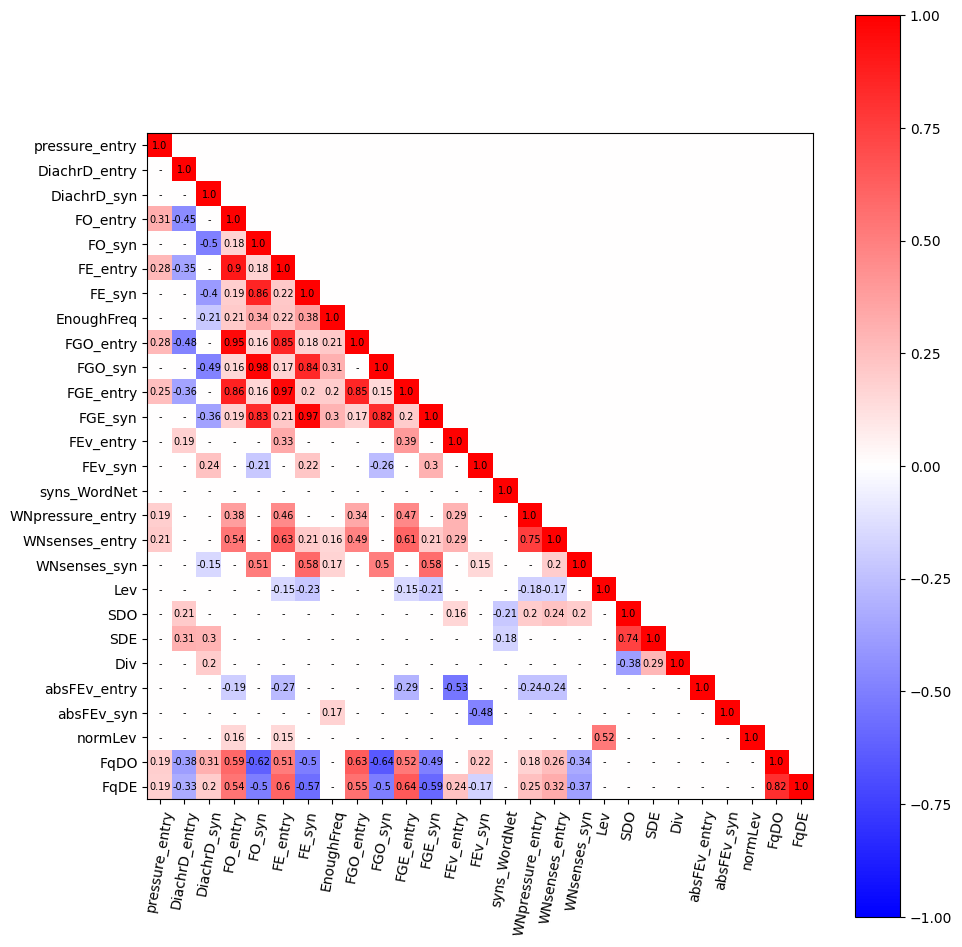

In [9]:
corr = synpairs_df.corr(method='spearman')
corr_masked = corr.mask((corr < 0.15) & (corr > -0.15), 0)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()
im = ax.imshow(np.tril(corr_masked), vmin=-1,vmax=1, cmap='bwr')
ax.set_xticks(ticks=range(len(corr_masked)), labels=corr_masked.columns , rotation=80)
ax.set_yticks(ticks=range(len(corr_masked)), labels=corr_masked.columns )
ax.xaxis.set_ticks_position('bottom')
fig.colorbar(im)

for (j,i),label in np.ndenumerate(np.tril(corr_masked)):
    if i <= j:
        if label:
            ax.text(i,j,label.round(2),ha='center',va='center',size='7')
        else:
            ax.text(i,j,'-',ha='center',va='center',size='7')

plt.tight_layout()
plt.savefig(f'./img/{model_name}_{pos}_correlations_All.png',transparent=False,dpi=100)
plt.show()

## Relation between Frequency and Diachronic Distance

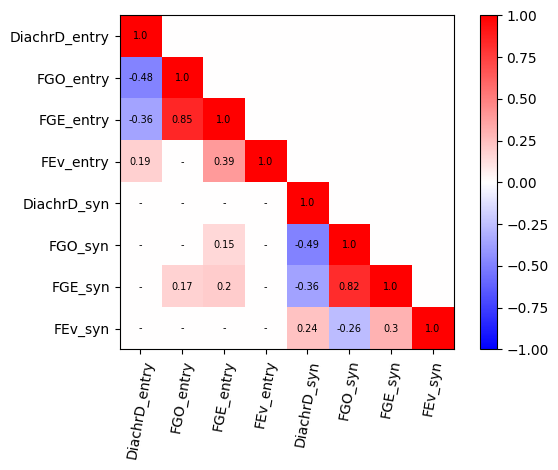

In [10]:
freq_corr = synpairs_df[['DiachrD_entry','FGO_entry','FGE_entry','FEv_entry','DiachrD_syn','FGO_syn','FGE_syn','FEv_syn']].corr(method='spearman')
freq_corr_masked = freq_corr.mask((freq_corr < 0.15) & (freq_corr > -0.15), 0)
corr = freq_corr_masked

fig = plt.figure()
ax = fig.add_subplot()
im = ax.imshow(np.tril(corr), vmin=-1,vmax=1, cmap='bwr')
ax.set_xticks(ticks=range(len(corr)), labels=corr.columns , rotation=80)
ax.set_yticks(ticks=range(len(corr)), labels=corr.columns )
fig.colorbar(im)

for (j,i),label in np.ndenumerate(np.tril(corr)):
    if i <= j:
        if label:
            ax.text(i,j,label.round(2),ha='center',va='center',size='7')
        else:
            ax.text(i,j,'-',ha='center',va='center',size='7')

plt.tight_layout()
plt.savefig(f'./img/{model_name}_{pos}_correlations_FreqDiachr.png',transparent=False,dpi=100)
plt.show()


Diachronic distance is correlated with frequency : low frequencies lead to poor representation leading to unstable representations and higher Diachronic distances.

## Relation between Synchronic Distances, pressure, frequency and being synonyms in WordNet (2005).

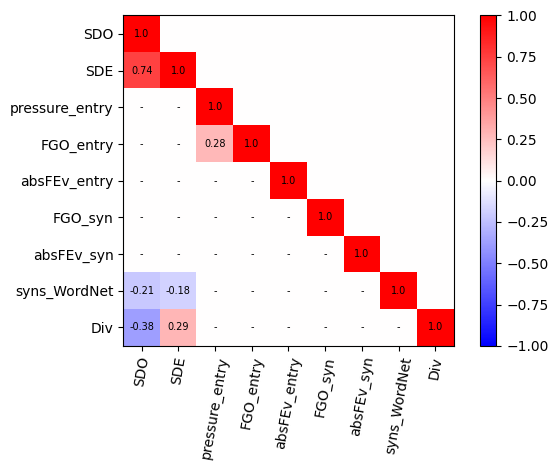

In [11]:
prox_corr = synpairs_df[['SDO','SDE','pressure_entry','FGO_entry','absFEv_entry','FGO_syn','absFEv_syn','syns_WordNet','Div']].corr(method='spearman')
prox_corr_masked = prox_corr.mask((prox_corr < 0.15) & (prox_corr > -0.15), 0)
corr = prox_corr_masked

fig = plt.figure()
ax = fig.add_subplot()
im = ax.imshow(np.tril(corr), vmin=-1,vmax=1, cmap='bwr')
ax.set_xticks(ticks=range(len(corr)), labels=corr.columns , rotation=80)
ax.set_yticks(ticks=range(len(corr)), labels=corr.columns )
fig.colorbar(im)

for (j,i),label in np.ndenumerate(np.tril(corr)):
    if i <= j:
        if label:
            ax.text(i,j,label.round(2),ha='center',va='center',size='7')
        else:
            ax.text(i,j,'-',ha='center',va='center',size='7')

plt.tight_layout()
plt.savefig(f'./img/{model_name}_{pos}_correlations_SdistPressureFreqWnsyns.png',transparent=False,dpi=100)
plt.show()

The synchronic distance is not correlated with frequency or frequency change.

The pressure over the entry (its number of synonyms) has no impact on the synnymy or the synchronic distance.

Divergence is not correlated with being synonyms in the 1990s. 

## Pressure, frequency and polysemy

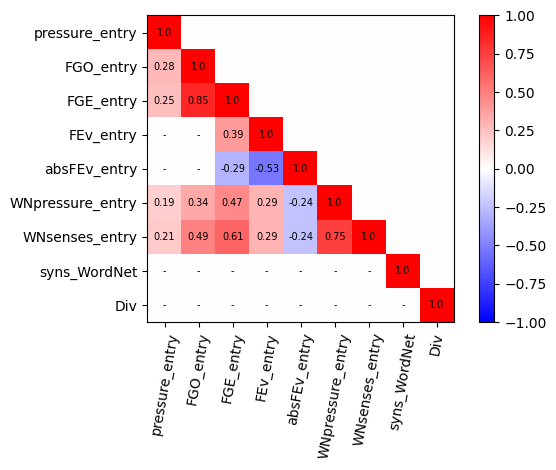

In [125]:
press_corr = synpairs_df[['pressure_entry','FGO_entry','FGE_entry','FEv_entry','absFEv_entry','WNpressure_entry','WNsenses_entry','syns_WordNet','Div']].corr(method='spearman')
press_corr_masked = press_corr.mask((press_corr < 0.15) & (press_corr > -0.15), 0)
corr = press_corr_masked

fig = plt.figure()
ax = fig.add_subplot()
im = ax.imshow(np.tril(corr), vmin=-1,vmax=1, cmap='bwr')
ax.set_xticks(ticks=range(len(corr)), labels=corr.columns , rotation=80)
ax.set_yticks(ticks=range(len(corr)), labels=corr.columns )
fig.colorbar(im)

for (j,i),label in np.ndenumerate(np.tril(corr)):
    if i <= j:
        if label:
            ax.text(i,j,label.round(2),ha='center',va='center',size='7')
        else:
            ax.text(i,j,'-',ha='center',va='center',size='7')

plt.tight_layout()
plt.savefig(f'./img/{model_name}_{pos}_correlations_PolysemyEntry.png',transparent=False,dpi=100)
plt.show()

Pressure is correlated with frequency : the more frequent words have more synonyms.

In WordNet, pressure (nb of syns) is highly correlated with polysemy : the more senses, the more synonyms. Therefore, at the begining, we can use pressure as a *proxy* for polysemy. 

Divergence is not correlated with any of the entry's polysemy indicator => there is no "competition" effect that would make a big synonyms group exlode.

# Impact analysis

## Has the difference between word forms an impact on synonymy ?

In [197]:
crosstab = pd.crosstab(synpairs_df.normLev > 1,synpairs_df.syns_WordNet)
proportion_crosstab = (crosstab / crosstab.sum(axis=1).values.reshape((2,1))).round(3)*100
proportion_crosstab.index = pd.Series(['0-1','1+'], name='Normalized Levenshtein')
proportion_crosstab
#crosstab

syns_WordNet,False,True
Normalized Levenshtein,,
0-1,86.2,13.8
1+,86.9,13.1


Proportions of synonymy are roughly the same, whether the word forms are similar or not : no impact.

## Has X factor an impact on the quality of predictions ?

In [75]:
synpairs_df['Results_avg'] = 'TP'
synpairs_df.loc[ (synpairs_df.syns_WordNet) & (synpairs_df.Dec_avg == 'LD') , 'Results_avg'] = 'FP'
synpairs_df.loc[ (~synpairs_df.syns_WordNet) & (synpairs_df.Dec_avg == 'LPC') , 'Results_avg'] = 'FN'
synpairs_df.loc[ (synpairs_df.syns_WordNet) & (synpairs_df.Dec_avg == 'LPC') , 'Results_avg'] = 'TN'

In [94]:
crosstab = pd.crosstab(synpairs_df.absFEv_entry > 1,synpairs_df.Results_avg)
(crosstab / crosstab.sum(axis=1).values.reshape((2,1))).round(3)*100

Results_avg,FN,FP,TN,TP
absFEv_entry,,,,
False,18.9,11.1,2.4,67.6
True,25.4,8.5,5.3,60.8


## Sanity check : synonym pairs that are still syns in 1990s are closer in 1990s.

<AxesSubplot: ylabel='Frequency'>

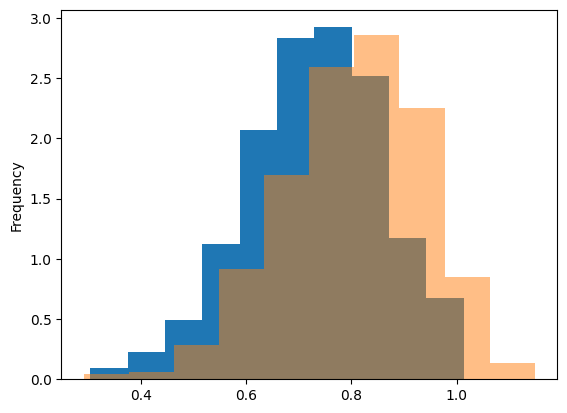

In [127]:
synpairs_df.loc[synpairs_df.syns_WordNet,'SDE'].plot.hist(x='SDE', density=True)
synpairs_df.loc[synpairs_df.syns_WordNet==False,'SDE'].plot.hist(x='SDE', alpha=0.5, density=True)


In [132]:
stats.ttest_ind(synpairs_df.loc[synpairs_df.syns_WordNet,'SDE'], synpairs_df.loc[~synpairs_df.syns_WordNet,'SDE'], alternative='less')

Ttest_indResult(statistic=-8.994698174994143, pvalue=2.4032892275375725e-19)

Significant p-value : the "still synonyms" pairs are closer than the "no longer synonyms" pairs.

# Retrieving word pairs

## Analysing the closest pairs of word forms.

In [148]:
synpairs_df.loc[synpairs_df.normLev < 0.4, ['entry','syn','EnoughFreq','DiachrDG_pair_avg','FqDO','FqDE','normLev','FGO_entry','FGO_syn','FGE_entry','FGE_syn','syns_WordNet', 'Dec_avgstd'] ]

,entry,syn,EnoughFreq,DiachrDG_pair_avg,FqDO,FqDE,normLev,FGO_entry,FGO_syn,FGE_entry,FGE_syn,syns_WordNet,Dec_avgstd
pairIdx,,,,,,,,,,,,,
53,accident,incident,True,,1,1,0.250000,4,3,3,2,False,LPC
98,agriculture,horticulture,True,syn,2,2,0.260870,2,0,2,0,False,LPC
261,appendage,appendix,True,entry,-1,0,0.352941,0,1,0,0,False,LD
322,artist,artisan,True,syn,3,4,0.307692,4,1,4,0,False,LD
459,benevolence,beneficence,False,syn,1,0,0.272727,1,0,0,0,False,LD
749,definition,description,True,,-1,1,0.380952,2,3,3,2,False,LPC
756,delegate,legate,False,syn,2,0,0.285714,2,0,0,0,False,LPC
763,delusion,illusion,True,entry,0,-2,0.250000,1,1,0,2,True,LPC
809,difference,divergence,True,syn,4,4,0.300000,4,0,4,0,True,LD


## Analysing word pairs in which one word frequency fell to 0.

In [167]:
synpairs_df.loc[ ((synpairs_df.FGO_entry > 1) & (synpairs_df.FGE_entry == 0)), ['entry','syn','EnoughFreq','DiachrDG_entry','DiachrDG_syn','FqDO','FqDE','FGO_entry','FGO_syn','FGE_entry','FGE_syn','syns_WordNet', 'Dec_avgstd'] ]

,entry,syn,EnoughFreq,DiachrDG_entry,DiachrDG_syn,FqDO,FqDE,FGO_entry,FGO_syn,FGE_entry,FGE_syn,syns_WordNet,Dec_avgstd
pairIdx,,,,,,,,,,,,,
755,delegate,deputy,True,,,1,-2,2,1,0,2,False,LPC
756,delegate,legate,False,,avg,2,0,2,0,0,0,False,LPC
757,delegate,proxy,True,,avg,2,0,2,0,0,0,False,LPC
758,delegate,representative,True,,,0,-1,2,2,0,1,False,LPC
759,delegate,substitute,True,,avg,2,0,2,0,0,0,False,LPC
1004,esteem,estimate,True,avg,,0,-1,2,2,0,1,False,LD
1005,esteem,estimation,True,avg,avg,1,-1,2,1,0,1,False,LD
1006,esteem,favor,True,avg,,-1,-2,2,3,0,2,False,LD
1007,esteem,regard,True,avg,,-1,-2,2,3,0,2,True,LD


In [168]:
synpairs_df.loc[ ((synpairs_df.FGO_syn > 1) & (synpairs_df.FGE_syn == 0)), ['entry','syn','EnoughFreq','DiachrDG_entry','DiachrDG_syn','FqDO','FqDE','FGO_entry','FGO_syn','FGE_entry','FGE_syn','syns_WordNet', 'Dec_avgstd'] ]

,entry,syn,EnoughFreq,DiachrDG_entry,DiachrDG_syn,FqDO,FqDE,FGO_entry,FGO_syn,FGE_entry,FGE_syn,syns_WordNet,Dec_avgstd
pairIdx,,,,,,,,,,,,,
35,abuse,reproach,True,avg,,0,3,2,2,3,0,False,LD
47,accident,misfortune,True,,,2,3,4,2,3,0,False,LD
48,accident,calamity,True,,,2,3,4,2,3,0,False,LPC
71,act,exertion,True,,,2,4,4,2,4,0,False,LPC
95,agriculture,cultivation,True,,,0,2,2,2,2,0,False,LPC
324,artist,workman,True,,,2,4,4,2,4,0,False,LD
326,association,confederacy,True,,avg,2,4,4,2,4,0,False,LPC
359,attachment,esteem,True,,avg,-1,1,1,2,1,0,False,LPC
476,blemish,reproach,True,avgstd,,-2,0,0,2,0,0,False,LD


In [191]:
word = 'atom'
synpairs_df.loc[(synpairs_df.syn == word) | (synpairs_df.entry == word ), ['entry','syn','EnoughFreq','DiachrDG_entry','DiachrDG_syn','WNsenses_entry','WNsenses_syn','FqDO','FqDE','FGO_entry','FGO_syn','FGE_entry','FGE_syn','syns_WordNet', 'Dec_avgstd']]

,entry,syn,EnoughFreq,DiachrDG_entry,DiachrDG_syn,WNsenses_entry,WNsenses_syn,FqDO,FqDE,FGO_entry,FGO_syn,FGE_entry,FGE_syn,syns_WordNet,Dec_avgstd
pairIdx,,,,,,,,,,,,,,,
1676,part,atom,True,avg,,13,2,3,3,4,1,4,1,False,LD
1690,particle,atom,True,,,3,2,0,0,1,1,1,1,True,LPC


## Analysing pairs where the frequency groups have reversed.

### Pairs in which entry was more frequent but now syn is more frequent.

In [164]:
synpairs_df.loc[ ((synpairs_df.FqDO > 0) & (synpairs_df.FqDE < 0)), ['entry','syn','EnoughFreq','DiachrDG_entry','DiachrDG_syn','FqDO','FqDE','FGO_entry','FGO_syn','FGE_entry','FGE_syn','syns_WordNet', 'Dec_avgstd'] ]

,entry,syn,EnoughFreq,DiachrDG_entry,DiachrDG_syn,FqDO,FqDE,FGO_entry,FGO_syn,FGE_entry,FGE_syn,syns_WordNet,Dec_avgstd
pairIdx,,,,,,,,,,,,,
59,acquaintance,intimacy,True,,avg,2,-1,4,2,1,2,False,LD
62,acquaintance,friendship,True,,,1,-1,4,3,1,2,False,LPC
105,aim,goal,True,,,1,-2,3,2,2,4,False,LPC
234,anxiety,concern,True,,,1,-2,3,2,2,4,False,LD
264,appetite,lust,True,,,1,-1,2,1,1,2,False,LPC
351,assurance,assumption,True,,,1,-1,3,2,1,2,False,LPC
491,blow,disaster,True,,,2,-1,4,2,2,3,False,LD
501,blow,shock,True,,,1,-1,4,3,2,3,True,LD
643,circumstance,item,True,,avg,1,-1,2,1,1,2,False,LD


### Pairs in which syn was more frequent but now entry is more frequent :

In [165]:
synpairs_df.loc[ ((synpairs_df.FqDO < 0) & (synpairs_df.FqDE > 0)), ['entry','syn','EnoughFreq','DiachrDG_entry','DiachrDG_syn','FqDO','FqDE','FGO_entry','FGO_syn','FGE_entry','FGE_syn','syns_WordNet', 'Dec_avgstd'] ]

,entry,syn,EnoughFreq,DiachrDG_entry,DiachrDG_syn,FqDO,FqDE,FGO_entry,FGO_syn,FGE_entry,FGE_syn,syns_WordNet,Dec_avgstd
pairIdx,,,,,,,,,,,,,
27,abuse,ruin,True,avg,,-1,2,2,3,3,1,False,LPC
33,abuse,harm,True,avg,,-1,1,2,3,3,2,False,LPC
188,anger,passion,True,,,-1,1,3,4,4,3,False,LPC
302,array,disposition,True,avgstd,avg,-1,1,2,3,2,1,False,LPC
359,attachment,esteem,True,,avg,-1,1,1,2,1,0,False,LPC
417,beat,strike,True,,avg,-1,2,1,2,4,2,False,LPC
419,beat,pound,True,,,-1,2,1,2,4,2,False,LPC
420,beat,whip,True,,,-1,3,1,2,4,1,False,LPC
422,beat,defeat,True,,,-2,2,1,3,4,2,False,LPC


# Fitting a model to predict LPC / LD

In [28]:
def print_scores(name, scores_arr, scores_names):
    for score, scorename in zip(scores_arr, scores_names):
        print(f'{name} {scorename} : {np.round(score,3)}')

def get_scores(y_preds,y_true):
    scores_values = [accuracy_score(y_true, y_preds), fbeta_score(y_true, y_preds, beta=1), fbeta_score(y_true, y_preds, beta=2), roc_auc_score(y_true, y_preds), matthews_corrcoef(y_true, y_preds)]
    scores_names = ['Test Accuracy', 'F1-score','F2-score','ROC-AUC','MCC']
    return (scores_values,scores_names)

In [29]:
scores_per_model = dict()
resultsSummary_per_dataset = dict()

In [30]:
target_var = synpairs_df.syns_WordNet
dataset_name = 'WordNet'

rng = np.random.default_rng(42)
target_var_counts = target_var.value_counts()
# Balancing group size : there can be AT MOST twice more False than True.
if target_var.mean() <= 1/3:
    p = (target_var_counts[True]*2)/target_var_counts[False]
else:
    p = 1

sample = pd.Series( rng.binomial(n=1,p=p,size=len(synpairs_df)) , index=synpairs_df.index)
X = synpairs_df.loc[ (target_var | sample) , :].copy()
Y = target_var[ (target_var | sample) ]

X['DDGpair_atleast1'] = X['DiachrDG_pair_avgstd'].astype(bool)
X['DDGpair_both'] = (X['DiachrDG_pair_avgstd'] == 'both')
X['DeltaDD'] = (X.DiachrD_entry - X.DiachrD_syn).abs()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42, shuffle=True)

In [31]:
print('Original True proportion :', target_var.mean())
print('Sampled True proportion :', Y.mean())
print('Sampled True proportion (train) :', y_train.mean())
print('Sampled True proportion (test) :', y_test.mean())

Original True proportion : 0.13546160483175151
Sampled True proportion : 0.3358288770053476
Sampled True proportion (train) : 0.3226837060702875
Sampled True proportion (test) : 0.36245954692556637


In [32]:
y_test.value_counts()

False    197
True     112
Name: syns_WordNet, dtype: int64

In [33]:
def loglikelihood(y_train,preds):
    return -log_loss(y_train, preds)*len(preds)

def aic(preds,y_train,n_features,n_train_samples):
    return -2/n_train_samples*loglikelihood(y_train,preds) + 2*n_features/n_train_samples

def bic(preds,y_train,n_features,n_train_samples):
    return -2*loglikelihood(y_train,preds)+ np.log(n_train_samples)*n_features

In [34]:
class DivergenceBasedClassifier:
    def __init__(self, threshold='avg'):
        self.threshold = threshold
    
    def fit(self, X,y):
        pass

    def predict(self,X):
        return ( X['Dec_'+self.threshold] == 'LPC' )

class ConstantOutputClassifier:
    def __init__(self,constant, out_type='bool'):
        self.constant = constant
        self.out_type = out_type

    def fit(self,X,y):
        pass

    def predict(self,X):
        return (np.ones(X.shape[0])*self.constant).astype(self.out_type)

class SynonymyClassif:

    def __init__(self, clf_model, features, kwargs_dict={}):
        self.kwargs = kwargs_dict
        self.model_constructor = clf_model
        self.model = clf_model(**kwargs_dict)
        self.features = features
        self.train_accuracy = 0

    def fit(self,X,y):
        self.model.fit(X[self.features], y)
        self.train_accuracy = accuracy_score(y_pred= self.predict(X),y_true=y)

    def predict(self,X):
        return self.model.predict(X[self.features])

    def score(self,X,y):
        return get_scores(y_preds=self.predict(X),y_true=y)

    def crosstab(self,X,y):
        return pd.crosstab(y, pd.Series(self.predict(X), name='Predictions', index = y.index ))

    def reinit(self, new_features = None):
        if new_features:
            self.__init__(self.model_constructor, new_features, self.kwargs)
        else:
            self.__init__(self.model_constructor, self.features, self.kwargs)
    
    def logreg_feature_selection(self, X, y, criterion_func):
        n_samples = y.shape[0]
        n_features = len(self.features)
        base_crit_value = criterion_func(self.predict(X),y,n_features,n_samples)
        selected_features = self.features.copy()
        best_crit_value = base_crit_value
        step_number = 0
        while True:
            crit_values = np.empty(len(selected_features))
            for i in range(len(selected_features)):
                reduced_features = selected_features[:i] + selected_features[i+1:] #exclude feature i
                self.reinit(reduced_features)
                self.fit(X,y)
                n_features = len(reduced_features)
                crit_values[i] = criterion_func(self.predict(X),y,n_features,n_samples)
            lowest_crit_value = np.min(crit_values)
            if lowest_crit_value > best_crit_value :
                break
            feature_to_remove_ind = np.argmin(crit_values)
            removed_feat = selected_features.pop(feature_to_remove_ind)
            best_crit_value = lowest_crit_value
            step_number += 1
        self.reinit(selected_features)
        self.fit(X,y)
        return {'init_crit_value' : base_crit_value, 'final_crit_value' : best_crit_value, 'nb_step' : step_number}
    
    def prune_decision_tree(self,X,y,evaluation_metric):
        pass    


In [36]:
features = ['DiachrD_entry','FGO_entry','FGE_entry','DiachrD_syn','FGO_syn','FGE_syn','normLev','SDO','SDE', 'Div','FqDO', 'FqDE', 'DDGpair_atleast1', 'DDGpair_both', 'DeltaDD']
synsSets_to_use = ['WordNet','WNExt']
minimum_TrueLabel_frequency = 0 # 0 for no sampling

resultsSummary_per_synSets = dict()

for synsSet in synsSets_to_use:
    target_var = synpairs_df['syns_'+synsSet]
    target_var_counts = target_var.value_counts()
    
    # Class balance
    rng = np.random.default_rng(42)
    if target_var.mean() <= minimum_TrueLabel_frequency : # 1/3 = there can be AT MOST twice more False than True.
        p = (target_var_counts[True]*2)/target_var_counts[False]
    else:
        p = 1 # Take everything
    sample = pd.Series( rng.binomial(n=1,p=p,size=len(synpairs_df)) , index=synpairs_df.index)
    
    # Datasets creation
    X = synpairs_df.loc[ (target_var | sample) , :].copy()
    Y = target_var[ (target_var | sample) ]
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42, shuffle=True)
    scores_per_model = dict()

    #===== Logistic Regression =====
    name = 'LogReg'
    clf = SynonymyClassif(
                    clf_model = LogisticRegression,
                    features = features,
                    kwargs_dict = {'class_weight':'balanced','max_iter':200, 'penalty':'l1', 'solver':'liblinear'}
                    )
    clf.fit(X_train,y_train)
    scores_per_model[name], scores_names = clf.score(X_test,y_test)

    #===== Feature-selected Logistic Regression =====
    name = 'FS-AIC LogReg'
    clf = SynonymyClassif(
                    clf_model = LogisticRegression,
                    features = features,
                    kwargs_dict = {'class_weight':'balanced','max_iter':200, 'penalty':'l1', 'solver':'liblinear'}
                    )
    clf.fit(X_train,y_train)
    clf.logreg_feature_selection(X_train,y_train,aic)
    scores_per_model[name], scores_names = clf.score(X_test,y_test)

    #===== Decision Tree =====
    name = 'Tree'
    clf = SynonymyClassif(
                    clf_model = DecisionTreeClassifier,
                    features = features,
                    kwargs_dict = {'class_weight':'balanced', 'max_depth':10 , 'criterion':'gini', 'min_samples_split':10}
                    )
    clf.fit(X_train,y_train)
    scores_per_model[name], scores_names = clf.score(X_test,y_test)
    
    #===== Pruned Decision Tree =====
    # name = 'Pruned Tree'
    # clf = SynonymyClassif(
    #                 clf_model = DecisionTreeClassifier,
    #                 features = features,
    #                 kwargs_dict = {'class_weight':'balanced', 'max_depth':10 , 'criterion':'gini', 'min_samples_split':10}
    #                 )
    # clf.fit(X_train,y_train)
    # clf.prune_decision_tree(X_train, y_train, evaluation_metric=matthews_corrcoef)
    # scores_per_model[name], scores_names = clf.score(X_test,y_test)
    
    #===== Random Forest =====
    name = 'Random Forest'
    n_trials = 20
    test_scores_list = []
    for i in range(n_trials):
        clf = SynonymyClassif(
                    clf_model = RandomForestClassifier,
                    features = features,
                    kwargs_dict = {'class_weight':'balanced', 'max_depth':10 , 'criterion':'gini', 'min_samples_split':10, 'n_estimators':10}
                    )
        clf.fit(X_train,y_train)
        test_scores, _ = clf.score(X_test,y_test)
        test_scores_list.append(test_scores)
    scores_per_model[name] = np.mean(test_scores_list,axis=0)
    
    #===== Divergence-based (threshold = avg) ======
    name = 'DivBased_avg'
    clf = SynonymyClassif(
                    clf_model = DivergenceBasedClassifier,
                    features = features + ['Dec_avg', 'Dec_avgstd'],
                    kwargs_dict = {'threshold':'avg'}
                    )
    clf.fit(X_train,y_train)
    scores_per_model[name], _ = clf.score(X_test,y_test)

    #===== Divergence-based (threshold = avgstd) ======
    name = 'DivBased_avgstd'
    clf = SynonymyClassif(
                    clf_model = DivergenceBasedClassifier,
                    features = features + ['Dec_avg', 'Dec_avgstd'],
                    kwargs_dict = {'threshold':'avgstd'}
                    )
    clf.fit(X_train,y_train)
    scores_per_model[name], _ = clf.score(X_test,y_test)

    #===== Always True ======
    name = 'AlwaysTrue'
    clf = SynonymyClassif(
                    clf_model = ConstantOutputClassifier,
                    features = features,
                    kwargs_dict = {'constant':1,'out_type':'bool'}
                    )
    clf.fit(X_train,y_train)
    scores_per_model[name], _ = clf.score(X_test,y_test)

    #===== Always False ======
    name = 'AlwaysFalse'
    clf = SynonymyClassif(
                    clf_model = ConstantOutputClassifier,
                    features = features,
                    kwargs_dict = {'constant':0,'out_type':'bool'}
                    )
    clf.fit(X_train,y_train)
    scores_per_model[name], _ = clf.score(X_test,y_test)

    #====== Summary ======
    resultsSummary_per_synSets[synsSet] = pd.DataFrame(data=scores_per_model,index=scores_names)


for dataname, df in resultsSummary_per_synSets.items():
    df['synsSet'] = dataname
    df['scores_names'] = scores_names
summary_df = pd.concat(resultsSummary_per_synSets.values())
summary_df = summary_df.set_index(['synsSet','scores_names']).round(3)

for synsSet in resultsSummary_per_synSets.keys():
    print('=========== ' + synsSet + ' ===========')
    display(summary_df.loc[synsSet])

=========== WordNet ===========


,LogReg,FS-AIC LogReg,Tree,Random Forest,DivBased_avg,DivBased_avgstd,AlwaysTrue,AlwaysFalse
scores_names,,,,,,,,
Test Accuracy,0.659,0.641,0.682,0.804,0.591,0.318,0.129,0.871
F1-score,0.343,0.321,0.283,0.272,0.156,0.174,0.229,0.000
F2-score,0.490,0.463,0.377,0.279,0.217,0.296,0.426,0.000
ROC-AUC,0.671,0.647,0.598,0.582,0.464,0.419,0.500,0.500
MCC,0.235,0.202,0.142,0.159,-0.050,-0.118,0.000,0.000


=========== WNExt ===========


,LogReg,FS-AIC LogReg,Tree,Random Forest,DivBased_avg,DivBased_avgstd,AlwaysTrue,AlwaysFalse
scores_names,,,,,,,,
Test Accuracy,0.725,0.720,0.719,0.775,0.605,0.376,0.217,0.783
F1-score,0.555,0.549,0.461,0.519,0.311,0.318,0.357,0.000
F2-score,0.675,0.669,0.513,0.543,0.363,0.464,0.581,0.000
ROC-AUC,0.749,0.743,0.659,0.697,0.535,0.482,0.500,0.500
MCC,0.418,0.408,0.286,0.375,0.059,-0.032,0.000,0.000


## Logistic Regression

In [44]:
#features = ['DiachrD_entry','DiachrD_syn','SDO','SDE','FGO_entry','FGE_entry','FGO_syn','FGE_syn', 'DeltaDD']

logreg = LogisticRegression(class_weight='balanced',max_iter=200, penalty='l1', solver='liblinear')
logreg.fit(X_train[features],y_train)
lr_preds = logreg.predict(X_test[features])

print('Train acc: ', logreg.score(X_train[features], y_train).round(3))
scores, scores_names = get_scores(y_preds=lr_preds,y_true=y_test)
print_scores('LogReg', scores, scores_names)

scores_per_model['LogReg'] = scores

print(pd.Series(index=features,data=logreg.coef_[0].round(3)).sort_values())
pd.crosstab( y_test, pd.Series(lr_preds,name='Predictions', index=y_test.index) )

Train acc:  0.715
LogReg Test Accuracy : 0.748
LogReg F1-score : 0.67
LogReg F2-score : 0.714
LogReg ROC-AUC : 0.748
LogReg MCC : 0.476
SDE                -6.871
SDO                -2.495
normLev            -0.201
DDGpair_atleast1   -0.116
FGO_syn            -0.060
FGO_entry           0.000
Div                 0.000
FqDE                0.000
DeltaDD             0.000
FqDO                0.009
FGE_entry           0.129
FGE_syn             0.208
DDGpair_both        0.759
DiachrD_entry       0.950
DiachrD_syn         2.228
dtype: float64


Predictions,False,True
syns_WNExt,,
False,244,82
True,43,127


### Selecting features with AIC/BIC

In [46]:
criterion_func = bic
features = ['DiachrD_entry','FGO_entry','FGE_entry','DiachrD_syn','FGO_syn','FGE_syn','normLev','SDO','SDE','FqDO', 'FqDE', 'DDGpair_atleast1', 'DDGpair_both', 'DeltaDD','Div']


logreg = LogisticRegression(class_weight='balanced',max_iter=200, penalty='l1', solver='liblinear')
logreg.fit(X_train[features],y_train)
n_train_samples = y_train.shape[0]
n_features = len(features)
train_preds = logreg.predict(X_train[features])
base_crit_value = criterion_func(train_preds,y_train,n_features,n_train_samples)
print('Base Criterion value : ', base_crit_value)

print('Start features selection...')
selected_features = features.copy()
best_crit_value = base_crit_value
step_number = 0
while True:
    print(f'Step {step_number}, crit_value={best_crit_value}, n_features={len(selected_features)} \nfeatures={selected_features}')
    crit_values = np.empty(len(selected_features))
    for i, feat_name in enumerate(selected_features):
        reduced_features = selected_features[:i] + selected_features[i+1:] #exclude feature i
        logreg = LogisticRegression(class_weight='balanced',max_iter=200, penalty='l1', solver='liblinear')
        logreg.fit(X_train[reduced_features],y_train)
        n_features = len(reduced_features)
        train_preds = logreg.predict(X_train[reduced_features])
        crit_values[i] = criterion_func(train_preds,y_train,n_features,n_train_samples)
    lowest_crit_value = np.min(crit_values)
    if lowest_crit_value > best_crit_value :
        print('No feature to remove. Finished features selection.\n')
        break
    feature_to_remove_ind = np.argmin(crit_values)
    removed_feat = selected_features.pop(feature_to_remove_ind)
    best_crit_value = lowest_crit_value
    print(f'Removed features "{removed_feat}", new crit value = {lowest_crit_value}.\n')
    step_number += 1
print('Selected features : ', selected_features)
print('Criterion value : ', best_crit_value)


Base Criterion value :  19929.28035152098
Start features selection...
Step 0, crit_value=19929.28035152098, n_features=15 
features=['DiachrD_entry', 'FGO_entry', 'FGE_entry', 'DiachrD_syn', 'FGO_syn', 'FGE_syn', 'normLev', 'SDO', 'SDE', 'FqDO', 'FqDE', 'DDGpair_atleast1', 'DDGpair_both', 'DeltaDD', 'Div']
Removed features "FGE_entry", new crit value = 19784.208310200956.

Step 1, crit_value=19784.208310200956, n_features=14 
features=['DiachrD_entry', 'FGO_entry', 'DiachrD_syn', 'FGO_syn', 'FGE_syn', 'normLev', 'SDO', 'SDE', 'FqDO', 'FqDE', 'DDGpair_atleast1', 'DDGpair_both', 'DeltaDD', 'Div']
Removed features "FGO_entry", new crit value = 19777.2945728503.

Step 2, crit_value=19777.2945728503, n_features=13 
features=['DiachrD_entry', 'DiachrD_syn', 'FGO_syn', 'FGE_syn', 'normLev', 'SDO', 'SDE', 'FqDO', 'FqDE', 'DDGpair_atleast1', 'DDGpair_both', 'DeltaDD', 'Div']
Removed features "DeltaDD", new crit value = 19770.38083549964.

Step 3, crit_value=19770.38083549964, n_features=12 
fea

In [47]:
reduced_logreg = LogisticRegression(class_weight='balanced',max_iter=200, penalty='l1', solver='liblinear')
reduced_logreg.fit(X_train[selected_features],y_train)
redlr_preds = reduced_logreg.predict(X_test[selected_features])

print('Train acc: ', reduced_logreg.score(X_train[selected_features], y_train).round(3))
scores, scores_names = get_scores(y_preds=redlr_preds,y_true=y_test)
print_scores('Reduced LogReg', scores, scores_names)

scores_per_model['Reduced LogReg'] = scores

pd.crosstab( y_test, pd.Series(redlr_preds,name='Predictions', index=y_test.index) )

Train acc:  0.722
Reduced LogReg Test Accuracy : 0.732
Reduced LogReg F1-score : 0.655
Reduced LogReg F2-score : 0.704
Reduced LogReg ROC-AUC : 0.734
Reduced LogReg MCC : 0.448


Predictions,False,True
syns_WNExt,,
False,237,89
True,44,126


## Decision Trees

In [48]:
params_tree = {'class_weight':'balanced', 'max_depth':10 , 'criterion':'gini', 'min_samples_split':10}
tree = DecisionTreeClassifier(**params_tree)

features = ['DiachrD_entry','FGO_entry','FGE_entry','DiachrD_syn','FGO_syn','FGE_syn','normLev','SDO','SDE','FqDO', 'FqDE', 'DDGpair_atleast1', 'DDGpair_both', 'DeltaDD','Div']
#features = ['FGO_entry','FGE_entry','FGO_syn','FGE_syn','FqDO', 'FqDE']

tree.fit(X_train[features],y_train)
tree_preds = tree.predict(X_test[features])

print('Train acc: ', tree.score(X_train[features], y_train).round(3))
scores, scores_names = get_scores(y_preds=tree_preds,y_true=y_test)
print_scores('Decision Tree', scores, scores_names)

scores_per_model['Decision Tree'] = scores

pd.crosstab( y_test, pd.Series(tree_preds,name='Predictions', index=y_test.index) )

Train acc:  0.861
Decision Tree Test Accuracy : 0.688
Decision Tree F1-score : 0.589
Decision Tree F2-score : 0.626
Decision Tree ROC-AUC : 0.679
Decision Tree MCC : 0.345


Predictions,False,True
syns_WNExt,,
False,230,96
True,59,111


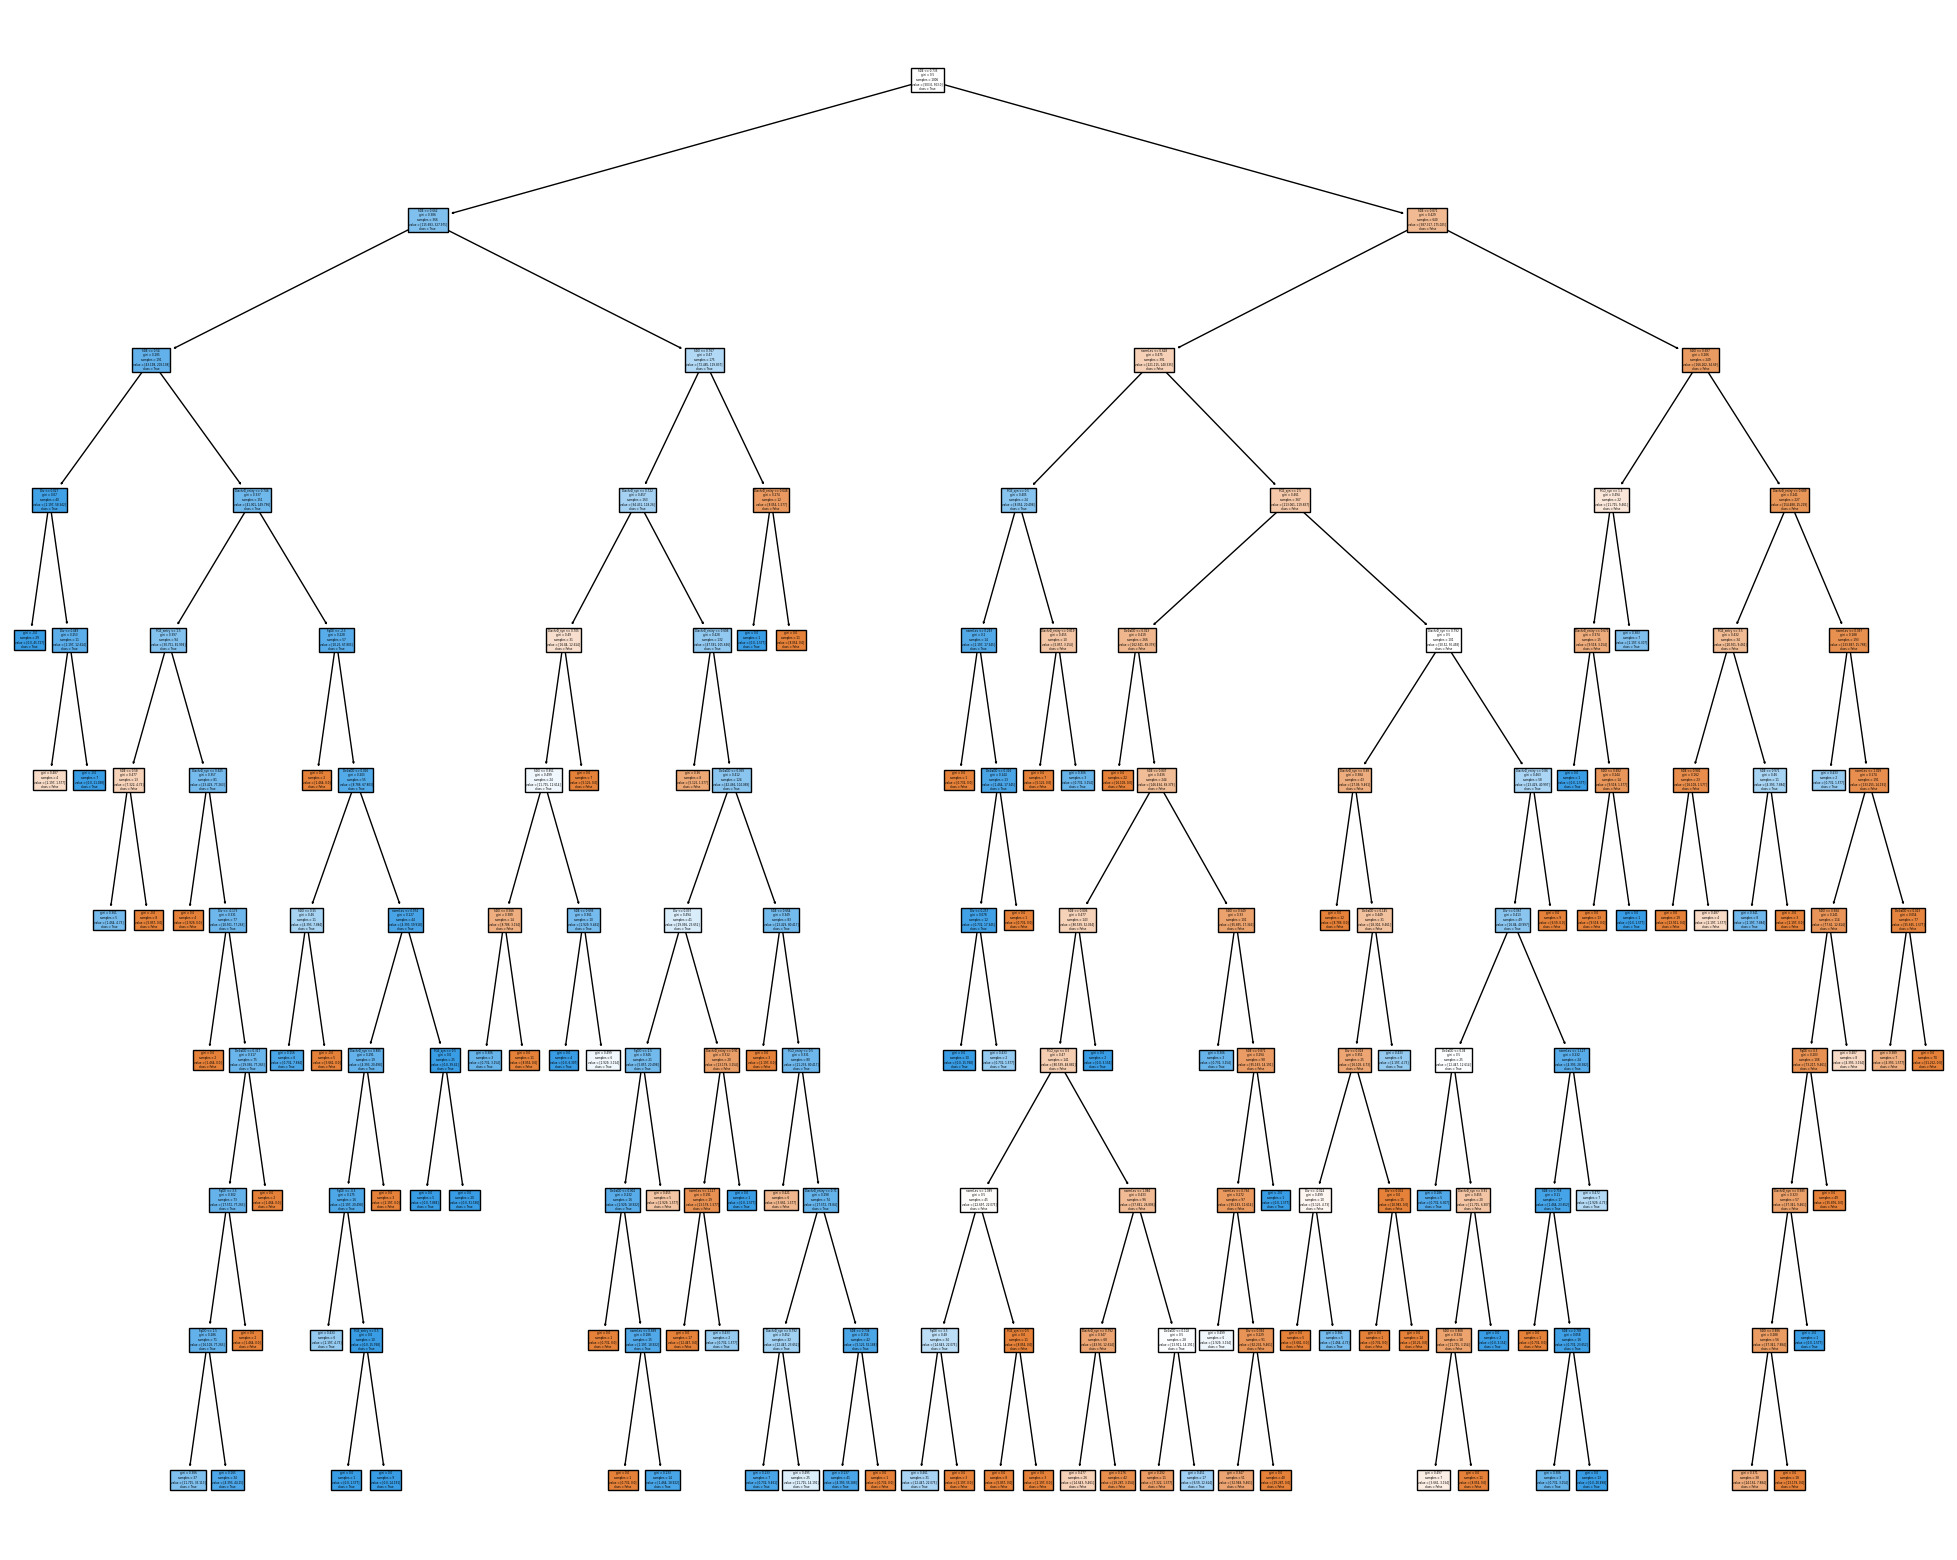

In [49]:
plt.figure(figsize=(25,20))
plot_tree(tree, filled=True, feature_names=features, class_names=Y.value_counts().index.astype(str))
plt.savefig('./img/decision_tree.png', dpi=200, transparent=False)
plt.show()

### Pruning the Decision Tree

In [50]:
path = tree.cost_complexity_pruning_path(X_train[features], y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha, **params_tree)
    clf.fit(X_train[features], y_train)
    clfs.append(clf)
print(len(clfs))

56


In [51]:
best_scores, scores_names = get_scores(y_preds=tree.predict(X_train[features]),y_true=y_train)
best_trees = np.zeros(len(best_scores),dtype='int32')

for i,pruned_tree in enumerate(clfs):
    prunedTree_preds = pruned_tree.predict(X_train[features])
    this_scores, _ = get_scores(y_preds=prunedTree_preds,y_true=y_train)
    for j,best_value in enumerate(best_scores):
        if this_scores[j] >= best_value :
            best_scores[j] = this_scores[j]
            best_trees[j] = i

print(list(zip(scores_names,best_scores,best_trees)))


[('Test Accuracy', 0.8608349900596421, 0), ('F1-score', 0.8050139275766016, 0), ('F2-score', 0.862686567164179, 0), ('ROC-AUC', 0.8729198322633046, 0), ('MCC', 0.7094771169538222, 0)]


Train acc:  0.715
Pruned Tree Test Accuracy : 0.686
Pruned Tree F1-score : 0.52
Pruned Tree F2-score : 0.536
Pruned Tree ROC-AUC : 0.648
Pruned Tree MCC : 0.289


Predictions,False,True
syns_WordNet,,
False,158,53
True,43,52


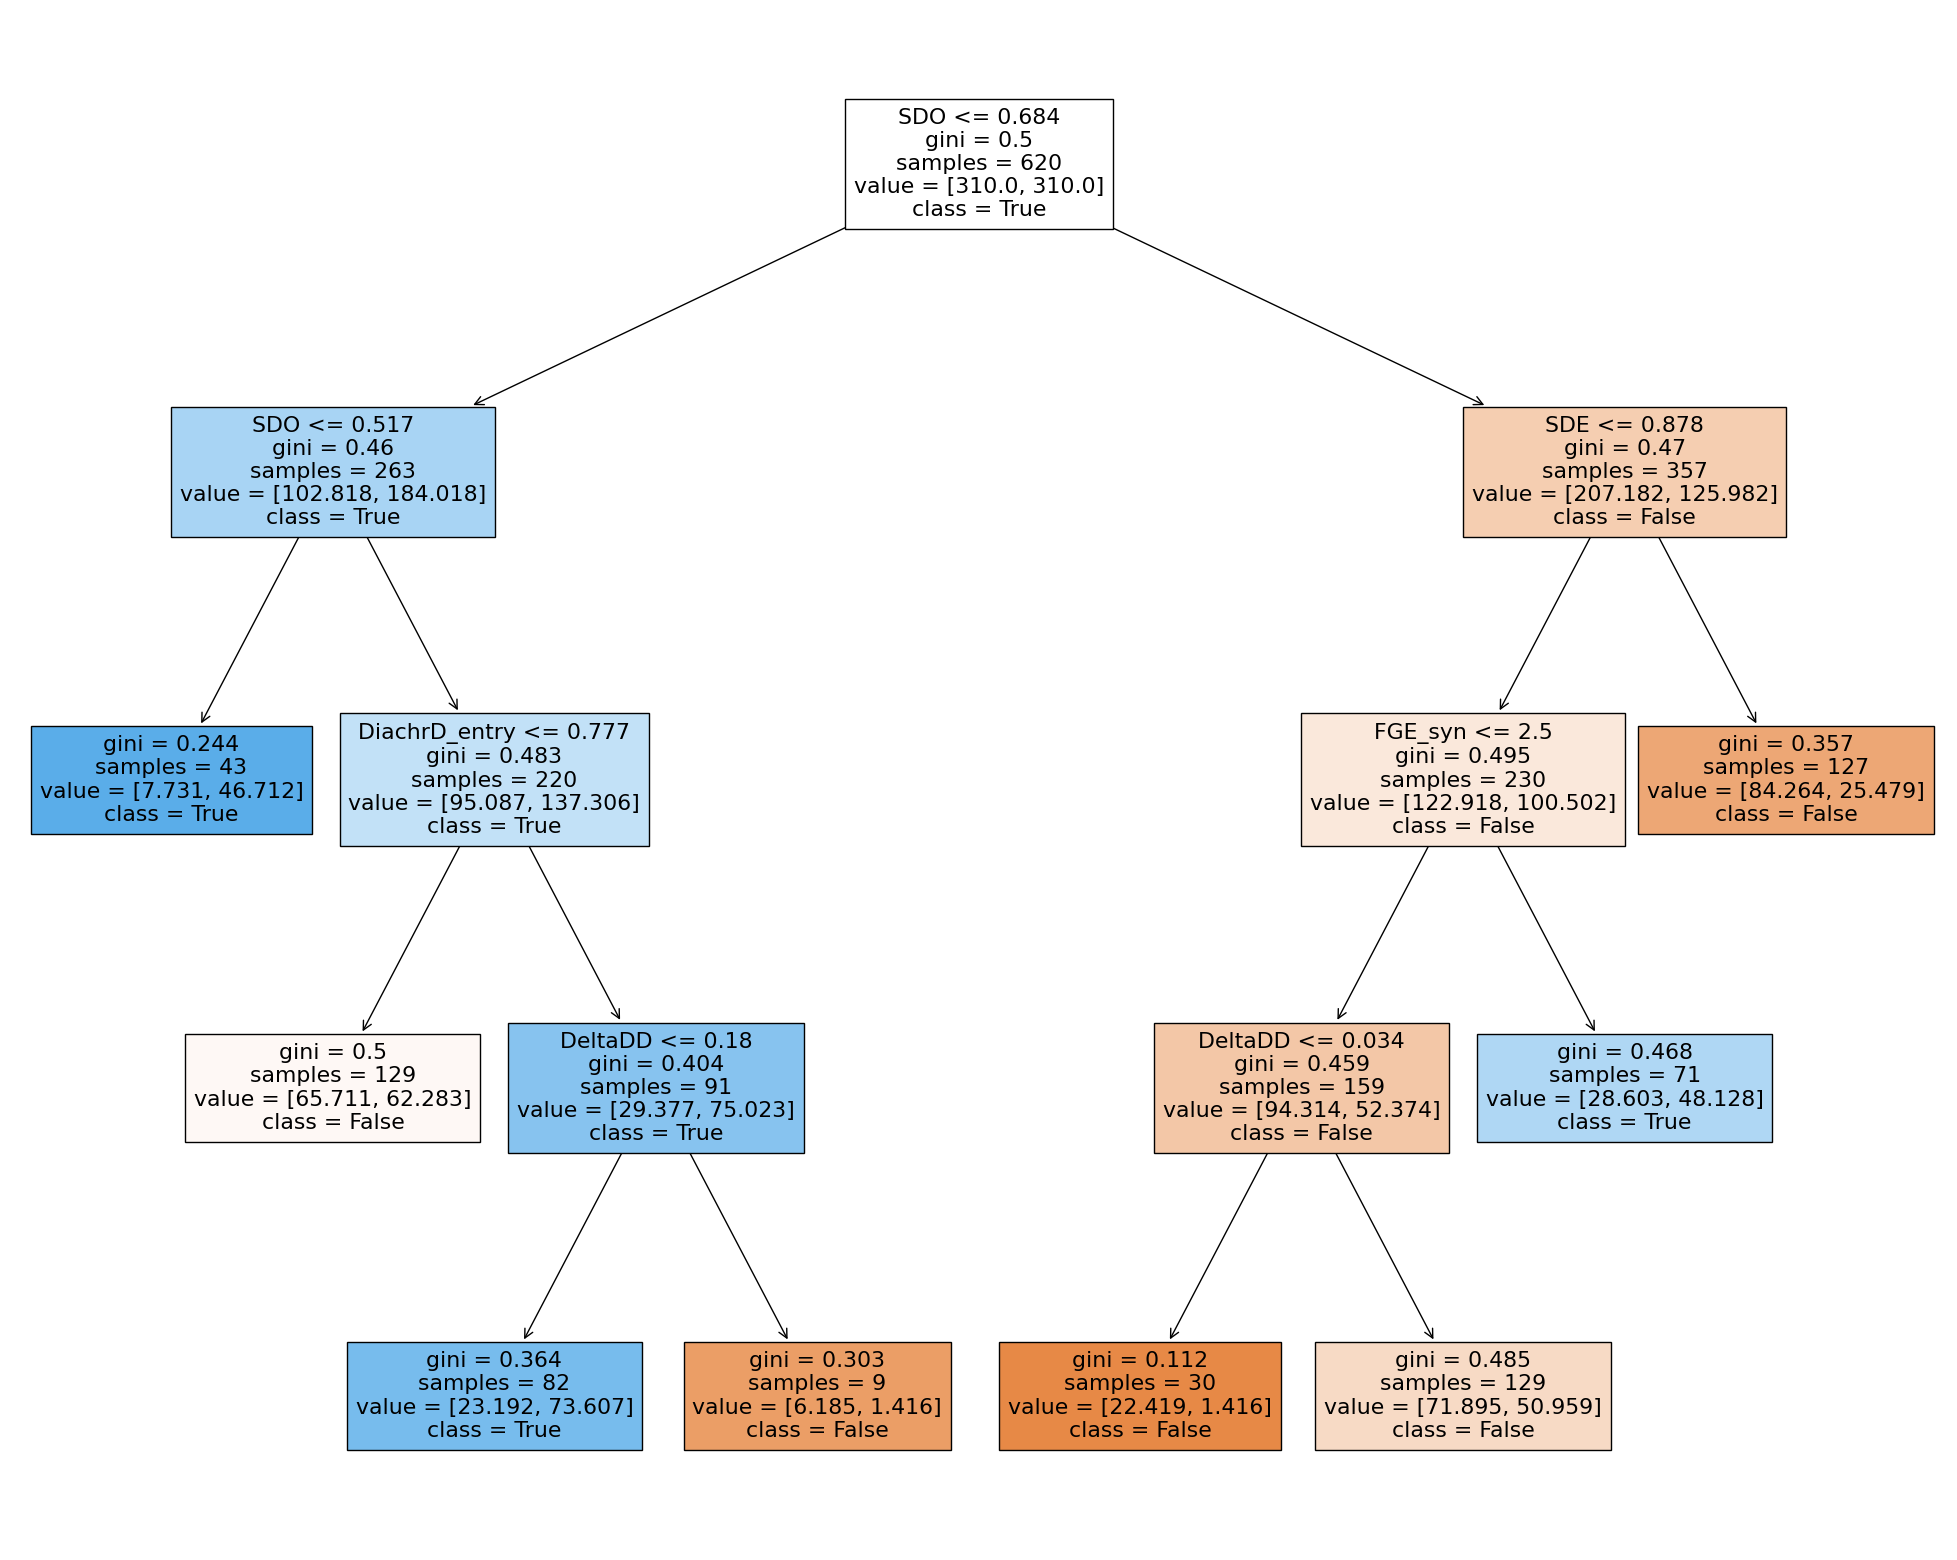

In [38]:
pruned_tree= clfs[ best_trees[-1] ] #select the one with best MCC 
prunedTree_preds = pruned_tree.predict(X_test[features])

print('Train acc: ', pruned_tree.score(X_train[features], y_train).round(3))
scores, scores_names = get_scores(y_preds=prunedTree_preds,y_true=y_test)
print_scores('Pruned Tree', scores, scores_names)

scores_per_model['Pruned Tree'] = scores

plt.figure(figsize=(25,20))
_ = plot_tree(pruned_tree, filled=True, feature_names=features, class_names=Y.value_counts().index.astype(str))
plt.savefig('./img/decision_tree.png', dpi=500, transparent=False)

pd.crosstab( y_test, pd.Series(prunedTree_preds,name='Predictions', index=y_test.index) )

#plt.show()

## Random Forest

In [39]:
features = ['DiachrD_entry','FGO_entry','FGE_entry','DiachrD_syn','FGO_syn','FGE_syn','normLev','SDO','SDE','FqDO','FqDE',]

n_trials = 20
trainaccs = np.empty(n_trials)
test_scores_list = []

for i in range(n_trials):
    randfor = RandomForestClassifier(class_weight='balanced', n_estimators=10 ,max_depth=10, max_leaf_nodes=None , criterion='gini')
    randfor.fit(X_train[features],y_train)
    randfor_preds = randfor.predict(X_test[features])
    trainaccs[i] = randfor.score(X_train[features], y_train).round(3)
    test_scores, scores_names = get_scores(y_preds=randfor_preds,y_true=y_test)
    test_scores_list.append(test_scores)

print('Train acc: ', trainaccs.mean().round(3))
test_scores_mean = np.mean(test_scores_list,axis=0)
print_scores('Random Forest', test_scores_mean, scores_names)

scores_per_model['Random Forest'] = test_scores_mean

pd.crosstab( y_test, pd.Series(randfor_preds,name='Predictions', index=y_test.index) )

Train acc:  0.955
Random Forest Test Accuracy : 0.667
Random Forest F1-score : 0.448
Random Forest F2-score : 0.441
Random Forest ROC-AUC : 0.604
Random Forest MCC : 0.21


Predictions,False,True
syns_WordNet,,
False,164,47
True,61,34


## Divergence based method

In [40]:
div_method_preds = (X_test['Dec_avgstd' ] == 'LPC')
div_method_preds.name = 'Div-based preds'

scores, scores_names = get_scores(y_preds=div_method_preds,y_true=y_test)
print_scores('Divergence-based', scores, scores_names)

scores_per_model['Divergence-based'] = scores

pd.crosstab( y_test, div_method_preds )

Divergence-based Test Accuracy : 0.48
Divergence-based F1-score : 0.361
Divergence-based F2-score : 0.421
Divergence-based ROC-AUC : 0.479
Divergence-based MCC : -0.04


Div-based preds,False,True
syns_WordNet,,
False,102,109
True,50,45


## Predicting always the same output

In [41]:
only1_preds = pd.Series(np.ones(y_test.shape), name='AlwaysTrue', index=y_test.index).astype('bool')

scores, scores_names = get_scores(y_preds=only1_preds,y_true=y_test)
print_scores('Always True', scores, scores_names)

scores_per_model['Always True'] = scores

pd.crosstab( y_test, only1_preds )

Always True Test Accuracy : 0.31
Always True F1-score : 0.474
Always True F2-score : 0.692
Always True ROC-AUC : 0.5
Always True MCC : 0.0


AlwaysTrue,True
syns_WordNet,
False,211
True,95


In [42]:
only0_preds = pd.Series(np.zeros(y_test.shape), name='AlwaysFalse', index=y_test.index).astype('bool')

scores, scores_names = get_scores(y_preds=only0_preds,y_true=y_test)
print_scores('Always False', scores, scores_names)

scores_per_model['Always False'] = scores

pd.crosstab( y_test, only0_preds )

Always False Test Accuracy : 0.69
Always False F1-score : 0.0
Always False F2-score : 0.0
Always False ROC-AUC : 0.5
Always False MCC : 0.0


AlwaysFalse,False
syns_WordNet,
False,211
True,95


## Summary

In [53]:
resultsSummary_per_dataset[dataset_name] = pd.DataFrame(data=scores_per_model,index=scores_names)

In [67]:
for dataname, df in resultsSummary_per_dataset.items():
    df['dataset'] = dataname
    df['scores_names'] = scores_names

In [79]:
crosstab = pd.crosstab(synpairs_df.Dec_avg, synpairs_df.syns_WordNet)
crosstab['Total'] = crosstab.sum(axis=1)
crosstab.loc['Total'] = crosstab.sum(axis=0)
crosstab

syns_WordNet,False,True,Total
Dec_avg,,,
LD,1284,210,1494
LPC,720,104,824
Total,2004,314,2318


# Unsupervised method analysis

In [93]:
groups = synpairs_df.groupby(['syns_WordNet','Dec_avg'])

print('=== Linguistic Variables ===')
ling_variables = ['pressure_entry','WNpressure_entry','WNsenses_entry','WNsenses_syn','Lev','normLev','syns_WNExt']
tab = groups[ling_variables].agg(['mean']).round(3)
tab['size'] = groups.size()
display(tab)

print('=== Frequency Variables ===')
frequency_variables = ['EnoughFreq','FGO_entry','FGE_entry','FGO_syn','FGE_syn','absFEv_entry','absFEv_syn','FqDO','FqDE']
tab = groups[frequency_variables].agg(['mean']).round(3)
tab['size'] = groups.size()
display(tab)

print('=== Diachronic Variables ===')
diachd_variables = ['DiachrD_entry','DiachrD_syn','DDGpair_atleast1','DDGpair_both','DeltaDD']
tab = groups[diachd_variables].agg(['mean']).round(3)
tab['size'] = groups.size()
display(tab)

print('=== Synchronic Variables ===')
synchd_variables = ['SDO','SDE','Div']
tab = groups[synchd_variables].agg(['mean']).round(3)
tab['size'] = groups.size()
display(tab)

=== Linguistic Variables ===


pressure_entry WNpressure_entry WNsenses_entry  \
                               mean             mean           mean   
syns_WordNet Dec_avg                                                  
False        LD              10.984            5.762          4.258   
             LPC             11.457            6.919          4.797   
True         LD               9.929            7.610          4.652   
             LPC              9.452            9.106          5.173   

                     WNsenses_syn    Lev normLev syns_WNExt  size  
                             mean   mean    mean       mean        
syns_WordNet Dec_avg                                               
False        LD             3.680  7.079   0.977      0.057  1284  
             LPC            4.093  6.832   0.987      0.142   720  
True         LD             4.024  6.390   0.918      1.000   210  
             LPC            4.423  6.942   1.033      1.000   104

=== Frequency Variables ===


EnoughFreq FGO_entry FGE_entry FGO_syn FGE_syn  \
                           mean      mean      mean    mean    mean   
syns_WordNet Dec_avg                                                  
False        LD           0.896     2.560     2.253   1.787   1.469   
             LPC          0.933     2.793     2.551   1.956   1.650   
True         LD           0.867     2.481     2.267   1.900   1.638   
             LPC          0.933     2.808     2.625   2.067   1.933   

                     absFEv_entry absFEv_syn   FqDO   FqDE  size  
                             mean       mean   mean   mean        
syns_WordNet Dec_avg                                              
False        LD             0.508      0.594  0.773  0.784  1284  
             LPC            0.519      0.669  0.838  0.901   720  
True         LD             0.529      0.605  0.581  0.629   210  
             LPC            0.529      0.519  0.740  0.692   104

=== Diachronic Variables ===


DiachrD_entry DiachrD_syn DDGpair_atleast1 DDGpair_both  \
                              mean        mean             mean         mean   
syns_WordNet Dec_avg                                                           
False        LD              0.776       0.821            0.191        0.012   
             LPC             0.754       0.799            0.114        0.004   
True         LD              0.783       0.831            0.186        0.019   
             LPC             0.755       0.792            0.038        0.000   

                     DeltaDD  size  
                        mean        
syns_WordNet Dec_avg                
False        LD        0.117  1284  
             LPC       0.104   720  
True         LD        0.112   210  
             LPC       0.100   104

=== Synchronic Variables ===


SDO    SDE    Div  size
                       mean   mean   mean      
syns_WordNet Dec_avg                           
False        LD       0.714  0.827  0.113  1284
             LPC      0.799  0.761 -0.037   720
True         LD       0.623  0.755  0.132   210
             LPC      0.721  0.685 -0.037   104

In [71]:
summary_df = pd.concat(resultsSummary_per_dataset.values())
summary_df = summary_df.set_index(['dataset','scores_names']).round(3)
summary_df.to_csv()
summary_df


LogReg  Reduced LogReg  Decision Tree  Pruned Tree  \
dataset scores_names                                                        
WNExt   Test Accuracy   0.736           0.738          0.682        0.750   
        F1-score        0.667           0.667          0.568        0.682   
        F2-score        0.714           0.711          0.583        0.728   
        ROC-AUC         0.739           0.739          0.662        0.753   
        MCC             0.460           0.461          0.318        0.487   
WordNet Test Accuracy   0.660           0.644          0.585        0.686   
        F1-score        0.567           0.544          0.441        0.520   
        F2-score        0.648           0.620          0.488        0.536   
        ROC-AUC         0.675           0.655          0.569        0.648   
        MCC             0.325           0.287          0.129        0.289   

                       Random Forest  Divergence-based  Always True  \
dataset scores_names                                                  
WNExt   Test Accuracy          0.743             0.516        0.352   
        F1-score               0.612             0.489        0.521   
        F2-score               0.590             0.578        0.731   
        ROC-AUC                0.705             0.548        0.500   
        MCC                    0.423             0.094        0.000   
WordNet Test Accuracy          0.667             0.480        0.310   
        F1-score               0.448             0.361        0.474   
        F2-score               0.441             0.421        0.692   
        ROC-AUC                0.604             0.479        0.500   
        MCC                    0.210            -0.040        0.000   

                       Always False  
dataset scores_names                 
WNExt   Test Accuracy         0.648  
        F1-score              0.000  
        F2-score              0.000  
        ROC-AUC               0.500  
        MCC                   0.000  
WordNet Test Accuracy         0.690  
        F1-score              0.000  
        F2-score              0.000  
        ROC-AUC               0.500  
        MCC                   0.000

# Miscellaneous

In [377]:
synpairs_df.entry.drop_duplicates()

pairIdx
0       absolute
20        absurd
36        active
54      adequate
62      adhesive
          ...   
1196      vacant
1200        vain
1220      verbal
1223    vigilant
1232    youthful
Name: entry, Length: 134, dtype: object

In [8]:
word = 'record'
synpairs_df.loc[ (synpairs_df.entry==word)|(synpairs_df.syn==word) , ['entry','syn','syns_WordNet','WNsenses_entry','WNpressure_entry'] ]

,entry,syn,syns_WordNet,WNsenses_entry,WNpressure_entry
pairIdx,,,,,


In [394]:
synpairs_df.entry.value_counts()

abide       17
keep        15
abolish     14
abandon     13
hinder      12
            ..
kill         1
call         1
tire         1
emigrate     1
mourn        1
Name: entry, Length: 107, dtype: int64

In [4]:
crosstab = pd.crosstab( synpairs_df.SDGE, synpairs_df.SDGO ).loc[['close','mid','far'],['close','mid','far']]
crosstab

SDGO,close,mid,far
SDGE,,,
close,225,152,2
mid,158,1233,167
far,2,162,217


In [9]:
synpairs_df.loc[ (synpairs_df.SDGO == 'far') & (synpairs_df.SDGE == 'mid'), ['entry','syn','DiachrDG_pair_avg','FO_entry','FO_syn','FE_entry','FE_syn','FEv_entry','FEv_syn','syns_WordNet','Div','Dec_avg','Dec_avgstd'] ]

,entry,syn,DiachrDG_pair_avg,FO_entry,FO_syn,FE_entry,FE_syn,FEv_entry,FEv_syn,syns_WordNet,Div,Dec_avg,Dec_avgstd
pairIdx,,,,,,,,,,,,,
6,abomination,abuse,both,28,242,29,808,0,0,False,-0.047147,LPC,LPC
10,abomination,annoyance,entry,28,181,29,122,0,0,False,-0.052271,LPC,LPC
11,abomination,disgust,entry,28,261,29,303,0,0,False,-0.016081,LPC,LPC
27,abuse,ruin,entry,242,460,808,147,0,-1,False,0.017428,LD,LPC
28,abuse,damage,entry,242,285,808,1004,0,0,False,0.005064,LD,LPC
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2234,utility,service,syn,131,4113,573,5294,1,0,False,-0.092937,LPC,LPC
2270,way,lane,entry,19582,269,30802,414,0,0,False,0.052521,LD,LPC
2287,wisdom,depth,,987,529,729,607,0,0,False,-0.002546,LD,LPC


In [10]:
synpairs_df.groupby('SDGO').agg('mean').loc[['close','mid','far']]

,pressure_entry,DiachrD_entry,DiachrD_syn,FO_entry,FO_syn,FE_entry,FE_syn,EnoughFreq,FGO_entry,FGO_syn,...,FEv_entry,FEv_syn,syns_WordNet,WNsenses_entry,WNsenses_syn,SDO,SDE,Div,absFEv_entry,absFEv_syn
SDGO,,,,,,,,,,,,,,,,,,,,,
close,9.732468,0.730255,0.781511,1196.719481,622.927273,1404.649351,675.454545,0.953247,2.683117,2.293506,...,-0.259740,-0.379221,0.280519,3.311688,2.968831,0.519225,0.635845,0.116619,0.306494,0.550649
mid,11.104072,0.771409,0.818741,1856.740142,675.616031,2325.950873,779.788623,0.948933,2.579186,2.212670,...,-0.153846,-0.266322,0.121526,4.548804,3.861668,0.734728,0.797980,0.063252,0.259858,0.501616
far,11.645078,0.796065,0.827471,2011.896373,860.246114,2624.898964,1037.129534,0.945596,2.536269,2.253886,...,-0.085492,-0.103627,0.046632,5.502591,4.818653,0.935326,0.935536,0.000210,0.225389,0.393782


In [4]:
# Remove pairs containing a word that is not in WordNet for more fair comparison
in_WN_df = synpairs_df.loc[ synpairs_df['WNsenses1'].astype(bool) & synpairs_df['WNsenses2'].astype(bool) ]
in_WN_df

,entry,syn,pressure_entry,SC1,SC2,SCgroup_avg,SCgroup_avgstd,FO1,FO2,FE1,...,FEvol1,FEvol2,syns_WordNet,WNsenses1,WNsenses2,SDO,SDE,Div,Dec_avg,Dec_avgstd
pairIdx,,,,,,,,,,,,,,,,,,,,,
0,abbreviation,abridgment,2,avg,avgstd,both,syn,9,22,8,...,0,0,False,2,1,0.859345,0.927214,0.067869,LD,LPC
1,abbreviation,contraction,2,avg,low,entry,,9,71,8,...,0,-1,False,2,4,0.782643,0.951685,0.169042,LD,LD
2,abomination,abhorrence,16,avg,avg,both,,28,44,29,...,0,-1,True,3,1,0.755047,0.924016,0.168969,LD,LD
3,abomination,curse,16,avg,low,entry,,28,298,29,...,0,-1,False,3,5,0.798238,0.754651,-0.043587,LPC,LPC
4,abomination,hatred,16,avg,low,entry,,28,327,29,...,0,0,False,3,1,0.779964,0.830752,0.050789,LD,LPC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2313,work,business,12,avg,low,entry,,12573,6685,13089,...,0,0,False,7,9,0.725191,0.813749,0.088558,LD,LD
2314,work,employment,12,avg,avg,both,,12573,632,13089,...,0,0,True,7,4,0.812646,0.789019,-0.023628,LPC,LPC
2315,work,performance,12,avg,avg,both,,12573,619,13089,...,0,0,False,7,5,0.687487,0.886413,0.198927,LD,LD


In [5]:
in_WN_Changed = in_WN_df.loc[in_WN_df['SCgroup_avgstd'].astype(bool)]
in_WN_Changed

,entry,syn,pressure_entry,SC1,SC2,SCgroup_avg,SCgroup_avgstd,FO1,FO2,FE1,...,FEvol1,FEvol2,syns_WordNet,WNsenses1,WNsenses2,SDO,SDE,Div,Dec_avg,Dec_avgstd
pairIdx,,,,,,,,,,,,,,,,,,,,,
0,abbreviation,abridgment,2,avg,avgstd,both,syn,9,22,8,...,0,0,False,2,1,0.859345,0.927214,0.067869,LD,LPC
13,abomination,villainy,16,avg,avgstd,both,syn,28,39,29,...,0,-1,False,3,2,0.823584,0.923543,0.099958,LD,LD
18,abridgment,abbreviation,6,avgstd,avg,both,entry,22,9,3,...,0,0,False,1,2,0.859345,0.927214,0.067869,LD,LPC
19,abridgment,epitome,6,avgstd,avgstd,both,both,22,35,3,...,0,0,False,1,2,0.717074,0.943577,0.226503,LD,LD
20,abridgment,summary,6,avgstd,low,entry,entry,22,139,3,...,0,0,False,1,1,0.822781,0.974527,0.151745,LD,LD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2282,way,roadway,18,avg,avgstd,both,syn,19582,106,30802,...,0,-1,False,12,1,0.839743,0.902788,0.063045,LD,LPC
2297,wisdom,erudition,18,low,avgstd,syn,syn,987,41,729,...,0,-1,False,5,1,0.792439,0.792871,0.000432,LD,LPC
2300,wisdom,profundity,18,low,avgstd,syn,syn,987,19,729,...,0,0,False,5,4,0.835593,0.876403,0.040810,LD,LPC


In [6]:
in_WN_Changed.loc[in_WN_Changed.syns_WordNet]['Dec_avgstd'].value_counts()

LD     31
LPC    12
Name: Dec_avgstd, dtype: int64

In [10]:
wn_synpairs_df = io.getWordNetSynpairsInfos(pos,model_name)
wn_synpairs_df = wn_synpairs_df.loc[ (wn_synpairs_df.FE1 >= 10) & (wn_synpairs_df.FE2 >= 10) ]
wn_synpairs_df

,index,syn1,syn2,SC1,SC2,SCgroup_avg,SCgroup_avgstd,FO1,FO2,FE1,...,FEvol2,WNsenses1,WNsenses2,SDO,SDE,Div,SDGO,SDGE,Dec_avg,Dec_avgstd
pairIdx,,,,,,,,,,,,,,,,,,,,,
1,1528,abandonment,defection,avg,avgstd,both,s2,127,36,95,...,-1,3,2,0.906758,0.913277,0.006519,mid,mid,LD,LPC
2,7755,abandonment,desertion,avg,avg,both,,127,82,95,...,-1,3,2,0.710151,0.961891,0.251740,mid,far,LD,LD
5,6871,abatement,hiatus,avg,avgstd,both,s2,25,7,26,...,1,2,3,0.859713,0.857328,-0.002385,mid,mid,LD,LPC
6,13359,abatement,reprieve,avg,avgstd,both,s2,25,19,26,...,1,2,4,0.578142,0.669337,0.091195,close,mid,LD,LD
7,10533,abatement,respite,avg,avg,both,,25,60,26,...,0,2,5,0.804172,0.804941,0.000769,mid,mid,LD,LPC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13571,1669,zero,cipher,low,avgstd,s2,s2,7,67,159,...,-2,4,5,0.445003,0.588934,0.143931,close,close,LD,LD
13572,1302,zest,nip,avgstd,avgstd,both,both,124,5,83,...,1,2,6,0.989210,0.823614,-0.165596,far,mid,LPC,LPC
13573,200,zest,relish,avgstd,avg,both,s1,124,74,83,...,-1,2,3,0.781737,0.676168,-0.105569,mid,mid,LPC,LPC


In [12]:
wn_synpairs_df.groupby('SDGE').agg('mean').loc[['close','mid','far']]

,index,FO1,FO2,FE1,FE2,EnoughFreq,FGO1,FGO2,FGE1,FGE2,FEvol1,FEvol2,WNsenses1,WNsenses2,SDO,SDE,Div
SDGE,,,,,,,,,,,,,,,,,
close,6832.816117,754.572742,759.322877,1025.294213,1015.875068,0.962142,2.073553,2.100054,2.074094,2.074635,0.000541,-0.025419,4.771769,4.808004,0.583762,0.571548,-0.012215
mid,6757.216353,736.796614,763.270020,972.059071,1003.790731,0.970104,2.087526,2.082483,2.106976,2.100973,0.019450,0.018490,4.763357,4.755913,0.781065,0.819574,0.038509
far,6815.311196,778.553787,652.714050,992.288145,856.790340,0.976400,2.066411,2.062569,2.060922,2.087816,-0.005488,0.025247,4.709111,4.706367,0.926509,1.004150,0.077641


In [42]:
import matplotlib.pyplot as plt 

In [43]:
distances_origin = io.getDistanceMatrix( pos, model_name, DECADES[0] )
distances_end = io.getDistanceMatrix( pos, model_name, DECADES[-1] )
semchanges = io.getSemChange(pos,model_name)

bin_count = 50
n_points = 50

if distance == 'cosine':
    max_dist = 2
    bin_count *= 2

distances_origin_pop = distances_origin.flatten()
distances_end_pop = distances_end.flatten()

# Subsampling for plot generation
if len(distances_end_pop) > 100000:
    sample_pop = np.random.randint(low=0,high=len(distances_end_pop),size=100000) # choose 100'000 randomly
else:
    sample_pop = list(range(len(distances_end_pop))) # all pairs



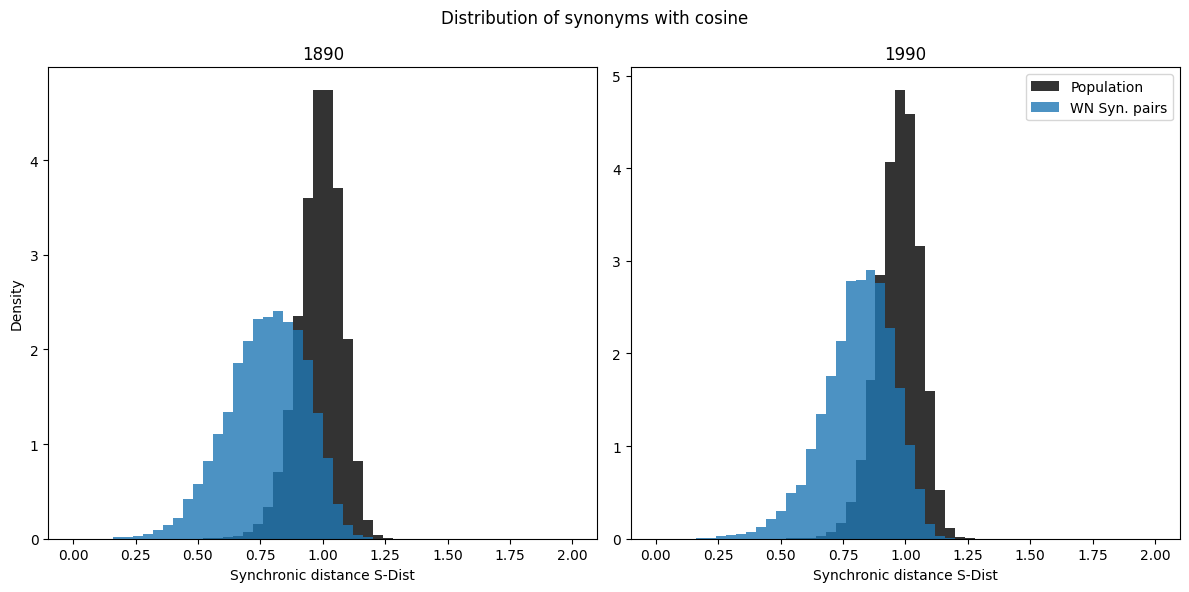

In [44]:
fig = plt.figure(figsize=(12,6))
fig.set_facecolor('white')
ax = fig.subplot_mosaic([['1890','1990']])
ax['1890'].hist(distances_origin_pop[sample_pop], bins=(np.arange(bin_count//2+1)*(max_dist/(bin_count//2))) , label='Population', color = COLORMAP['p'], alpha=0.8, density=True)
ax['1890'].hist(wn_synpairs_df.SDO, bins=(np.arange(bin_count//2+1)*(max_dist/(bin_count//2))) , label=f'WN Syn. pairs ({len(wn_synpairs_df)})', color = COLORMAP['s'], alpha=0.8, density=True)
ax['1890'].set_title('1890')
ax['1990'].hist(distances_end_pop[sample_pop], bins=(np.arange(bin_count//2+1)*(max_dist/(bin_count//2))) , label='Population', color = COLORMAP['p'], alpha=0.8, density=True)
ax['1990'].hist(wn_synpairs_df.SDE, bins=(np.arange(bin_count//2+1)*(max_dist/(bin_count//2))) , label='WN Syn. pairs', color = COLORMAP['s'], alpha=0.8, density=True)
ax['1990'].set_title('1990')
ax['1890'].set_ylabel('Density')
ax['1890'].set_xlabel('Synchronic distance S-Dist')
ax['1990'].set_xlabel('Synchronic distance S-Dist')
fig.suptitle(f'Distribution of synonyms with {distance}')
fig.tight_layout()
ax['1990'].legend()
plt.show()

In [16]:
in_WN_df = synpairs_df.loc[ synpairs_df['WNsenses1'].astype(bool) & synpairs_df['WNsenses2'].astype(bool) ]

In [51]:
in_WN_df.Dec_WN.value_counts()

LPC    2025
LD      277
Name: Dec_WN, dtype: int64

In [56]:
(~in_WN_df.syns_WordNet).value_counts()

True     1988
False     314
Name: syns_WordNet, dtype: int64

In [57]:
in_WN_df[['entry','syn','syns_WordNet','Dec_WN']]

,entry,syn,syns_WordNet,Dec_WN
pairIdx,,,,
0,abbreviation,abridgment,False,LPC
1,abbreviation,contraction,False,LD
2,abomination,abhorrence,True,LPC
3,abomination,curse,False,LPC
4,abomination,hatred,False,LPC
...,...,...,...,...
2313,work,business,False,LPC
2314,work,employment,True,LPC
2315,work,performance,False,LPC


In [90]:
crosstab = pd.crosstab( in_WN_df.syns_WordNet, in_WN_df.Dec_avg )
crosstab

Dec_avg,LD,LPC
syns_WordNet,,
False,1542,446
True,253,61


In [23]:
crosstab = pd.crosstab( in_WN_df.loc[in_WN_df.FEvol2 < 0].syns_WordNet, in_WN_df.loc[in_WN_df.FEvol2 < 0].Dec_avg )
crosstab

Dec_avg,LD,LPC
syns_WordNet,,
False,519,118
True,80,13


<AxesSubplot: ylabel='Frequency'>

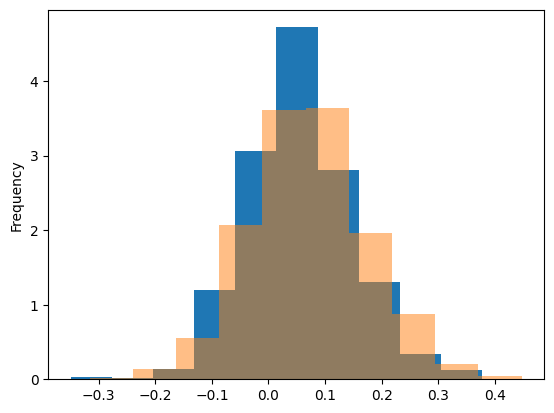

In [26]:
in_WN_df.loc[in_WN_df.absFEv2 < 1,'Div'].plot.hist(x='Div', density=True)
in_WN_df.loc[in_WN_df.absFEv2 >= 1,'Div'].plot.hist(x='Div', alpha=0.5, density=True)


In [17]:
crosstab = pd.crosstab( in_WN_df.loc[in_WN_df.EnoughFreq].syns_WordNet, in_WN_df.loc[in_WN_df.EnoughFreq].Dec_avg )
crosstab

Dec_avg,LD,LPC
syns_WordNet,,
False,1454,433
True,238,59


In [91]:
acc = (crosstab.loc[False,'LD'] + crosstab.loc[True,'LPC'] ) / len(in_WN_df)
acc

0.6963509991311903

In [19]:
synpairs_df.groupby('FEvol2').agg('mean')

,pressure_entry,SC1,SC2,FO1,FO2,FE1,FE2,EnoughFreq,FGO1,FGO2,...,FGE2,FEvol1,syns_WordNet,WNsenses1,WNsenses2,SDO,SDE,Div,absFEv1,absFEv2
FEvol2,,,,,,,,,,,,,,,,,,,,,
-3,13.500000,0.662073,0.853633,3979.000000,227.500000,4832.000000,18.000000,1.000000,3.000000,3.000000,...,0.000000,0.000000,0.500000,5.500000,1.500000,0.798724,0.798053,-0.000671,0.000000,3.0
-2,11.776923,0.769249,0.846808,1644.215385,156.830769,2079.192308,33.861538,0.938462,2.569231,2.369231,...,0.369231,-0.207692,0.107692,3.976923,2.092308,0.696364,0.809569,0.113206,0.269231,2.0
-1,10.938640,0.764705,0.821355,1329.041459,211.873964,1583.752902,98.640133,0.965174,2.500829,2.222222,...,1.222222,-0.235489,0.129353,3.810945,2.542289,0.702899,0.777128,0.074229,0.338308,1.0
0,10.970304,0.769307,0.798380,2011.475872,1079.294729,2553.538233,1291.146251,0.939866,2.625093,2.440238,...,2.440238,-0.128434,0.140312,4.742390,4.746102,0.744741,0.799075,0.054335,0.227914,0.0
1,10.666667,0.777474,0.862792,1579.921569,67.578431,2017.058824,257.656863,0.965686,2.612745,1.093137,...,2.093137,-0.147059,0.127451,5.147059,3.274510,0.756147,0.801685,0.045539,0.274510,1.0
2,9.448276,0.766850,0.888239,1570.103448,27.620690,1824.310345,317.275862,0.965517,2.620690,0.413793,...,2.413793,0.034483,0.206897,5.482759,3.517241,0.760694,0.792589,0.031895,0.172414,2.0
3,13.000000,0.752263,0.874113,3097.666667,20.000000,4428.000000,620.000000,1.000000,3.000000,0.000000,...,3.000000,0.000000,0.000000,4.333333,2.000000,0.703190,0.686941,-0.016249,0.000000,3.0
